# Introduction to Deep Learning with Keras and TensorFlow

To help you understand the fundamentals of deep learning, this demo will walk through the basic steps of building a toy model for classifying handwritten numbers with accuracies surpassing 95%. This model will be a basic fully-connected neural network.

## The Task for the AI

Our goal is to construct and train an artificial neural network on thousands of images of handwritten digits so that it may successfully identify others when presented. The data that will be incorporated is the MNIST database which contains 60,000 images for training and 10,000 test images. We will use the Keras Python API with TensorFlow as the backend.

![MNIST](https://www.researchgate.net/profile/Kofi_Appiah/publication/252028600/figure/fig2/AS:298067136925718@1448076151592/Some-samples-of-the-MNIST-database.png)

## Prerequisite Python Modules

First, some software needs to be loaded into the Python environment.

In [7]:
try:
    import tensorflow as tf
    if tf.__version__.startswith('2.4'):
        pass
    else:
        !pip3 install tensorflow-gpu==2.4.0
except:
    !pip3 install tensorflow-gpu==2.4.0
    
import tensorflow as tf
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers
import tensorflow.keras as keras

from tensorflow.keras.datasets import mnist     # MNIST dataset is included in Keras
from tensorflow.keras.models import Sequential  # Model type to be used

from tensorflow.keras.layers import Dense, Dropout, Activation # Types of layers to be used in our model

## Loading Training Data

The MNIST dataset is conveniently bundled within Keras, and we can easily analyze some of its features in Python.

In [8]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


Using matplotlib, we can plot some sample images from the training set directly into this Jupyter Notebook.

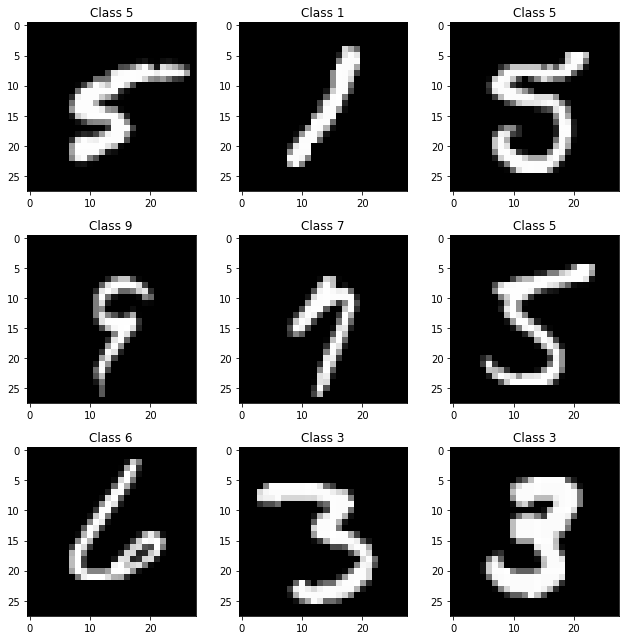

In [9]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    
plt.tight_layout()

Let's examine a single digit a little closer, and print out the array representing the last digit.

In [10]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!        
matprint(X_train[num])

0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  
0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  
0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  
0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  
0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  
0  0  0  0  0   0    0    0    0    0    0   48   96  194  255  253  253  253  253   96   24    0  0  0  0  0  0  0  
0  0  0  0  0   0    0    0    0    0  143  221  251  251  253  251  251  251  251  253  185   16  0  0  0  0  0  0  
0  0  0  0  0   0    0    0    0    0  190  251  251  251  253  251  251  251  251  253  251  126  0  0  0  0  0  0  
0  0  0  0  0   0    0    0    0    0  150  251  251  25

Each pixel is an 8-bit integer from 0-255. 0 is full black, while 255 is full white. This what we call a single-channel pixel. It's called monochrome.

*Fun-fact! Your computer screen has three channels for each pixel: red, green, blue. Each of these channels also likely takes an 8-bit integer. 3 channels -- 24 bits total -- 16,777,216 possible colors!*

## Formatting the input data layer

Instead of a 28 x 28 matrix, we build our network to accept a 784-length vector.

Each image needs to be then reshaped (or flattened) into a vector. We'll also normalize the inputs to be in the range [0-1] rather than [0-255]. Normalizing inputs is generally recommended, so that any additional dimensions (for other network architectures) are of the same scale.

![Flatten](https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/73_blog_image_1.png)

### Reshape the input and test data
Reshape the training and test data to a `60,000 x 784` and `10,000 x 784` matrix, cast it to `float32` and normalize it between `0` and `1`. 

In [11]:
X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


We then modify our classes (unique digits) to be in the one-hot format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

If the final output of our network is very close to one of these classes, then it is most likely that class. For example, if the final output is:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
then it is most probable that the image is that of the digit `1`.

Format `Y_train` and `Y_test` to a one hot encoding. Try using the `tensorflow.keras.utils.to_categorical` method for this!

In [26]:
nb_classes = 10 # number of unique digits

Y_train = keras.utils.to_categorical(y_train, nb_classes)
Y_test = keras.utils.to_categorical(y_test, nb_classes)

# Building a 3-layer fully connected network (FCN)
![3layerMLP](https://image.slidesharecdn.com/prezentacja-dlworks-180401184922/95/czy-deep-learning-dziaa-29-638.jpg?cb=1522608727)

In [13]:
# The Sequential model is a linear stack of layers and is very common.
model = Sequential()

## The first hidden layer
Add layers to the model using `model.add(...)`. See the documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#add)

In [14]:
# The first hidden layer is a set of 512 nodes (artificial neurons).
# Each node will receive an element from each input vector and apply some weight and bias to it.

model.add(Dense(512, input_shape=(784,))) #(784,) is not a typo -- that represents a 784 length vector!

In [15]:
# An "activation" is a non-linear function applied to the output of the layer above.
# It checks the new value of the node, and decides whether that artifical neuron has fired.
# The Rectified Linear Unit (ReLU) converts all negative inputs to nodes in the next layer to be zero.
# Those inputs are then not considered to be fired.
# Positive values of a node are unchanged.

model.add(Activation('relu'))

In [16]:
# Dropout zeroes a selection of random outputs (i.e., disables their activation)
# Dropout helps protect the model from memorizing or "overfitting" the training data.
model.add(Dropout(0.2))

## Adding the second hidden layer

In [17]:
# The second hidden layer appears identical to our first layer.
# However, instead of each of the 512-node receiving 784-inputs from the input image data,
# they receive 512 inputs from the output of the first 512-node layer.

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

## The Final Output Layer

In [18]:
# The final layer of 10 neurons in fully-connected to the previous 512-node layer.
# The final layer of a FCN should be equal to the number of desired classes (10 in this case).
model.add(Dense(10))

In [19]:
# The "softmax" activation represents a probability distribution over K different possible outcomes.
# Its values are all non-negative and sum to 1.

model.add(Activation('softmax'))

In [27]:
# Summarize the built model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5

## Compiling the model

Keras is built on top of Theano and TensorFlow. Both packages allow you to define a *computation graph* in Python, which then compiles and runs efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiing a model, Keras asks you to specify your **loss function** and your **optimizer**. The loss function we'll use here is called *categorical cross-entropy*, and is a loss function well-suited to comparing two probability distributions.

Our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. [More detail at Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)

The optimizer helps determine how quickly the model learns through **gradient descent**. The rate at which descends a gradient is called the **learning rate**.

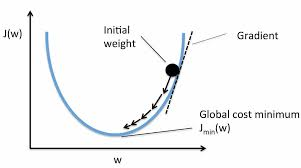
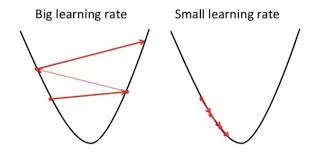
So are smaller learning rates better? Not quite! It's important for an optimizer not to get stuck in local minima while neglecting the global minimum of the loss function. Sometimes that means trying a larger learning rate to jump out of a local minimum.
![](https://cdn-ak.f.st-hatena.com/images/fotolife/r/robonchu/20171216/20171216162938.png)

Compile the model below

In [21]:
# Let's use the Adam optimizer for learning
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model!
This is the fun part! 

The batch size determines over how much data per step is used to compute the loss function, gradients, and back propagation. Large batch sizes allow the network to complete it's training faster; however, there are other factors beyond training speed to consider.

Too large of a batch size smoothes the local minima of the loss function, causing the optimizer to settle in one because it thinks it found the global minimum.

Too small of a batch size creates a very noisy loss function, and the optimizer may never find the global minimum.

So a good batch size may take some trial and error to find!

In [22]:
# Call the model.fit() function here. We recommend setting verbose=1
model.fit(X_train, Y_train,
          batch_size=128, epochs=5,
          verbose=1)

Epoch 1/5
469/469 [==============================] - 3s 6ms/step - loss: 0.4518 - accuracy: 0.8613
Epoch 2/5
469/469 [==============================] - 3s 5ms/step - loss: 0.1021 - accuracy: 0.9683
Epoch 3/5
469/469 [==============================] - 2s 5ms/step - loss: 0.0688 - accuracy: 0.9785
Epoch 4/5
469/469 [==============================] - 2s 5ms/step - loss: 0.0561 - accuracy: 0.9821
Epoch 5/5
469/469 [==============================] - 2s 5ms/step - loss: 0.0413 - accuracy: 0.9868


The two numbers, in order, represent the value of the loss function of the network on the training set, and the overall accuracy of the network on the training data. But how does it do on data it did not train on?

## Evaluate Model's Accuracy on Test Data

In [29]:
# Call model.evaluate()
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 0s 1ms/step - loss: 0.0627 - accuracy: 0.9816
Test score: 0.06267955899238586
Test accuracy: 0.9815999865531921


### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [24]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

/home/joris/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


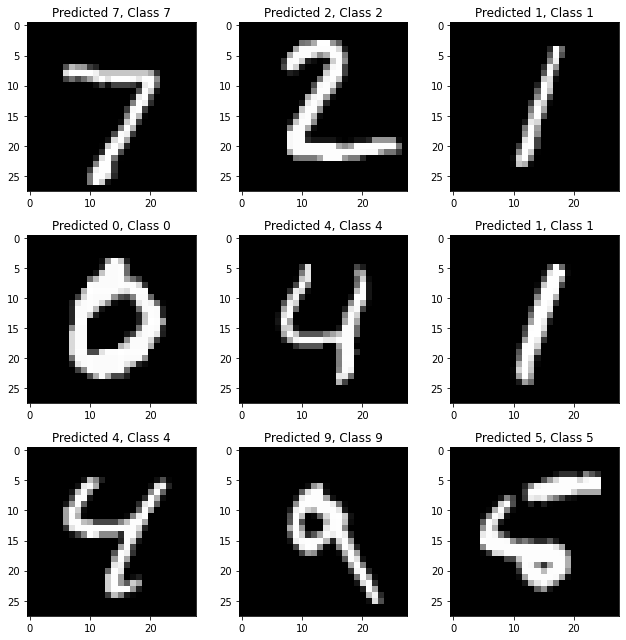

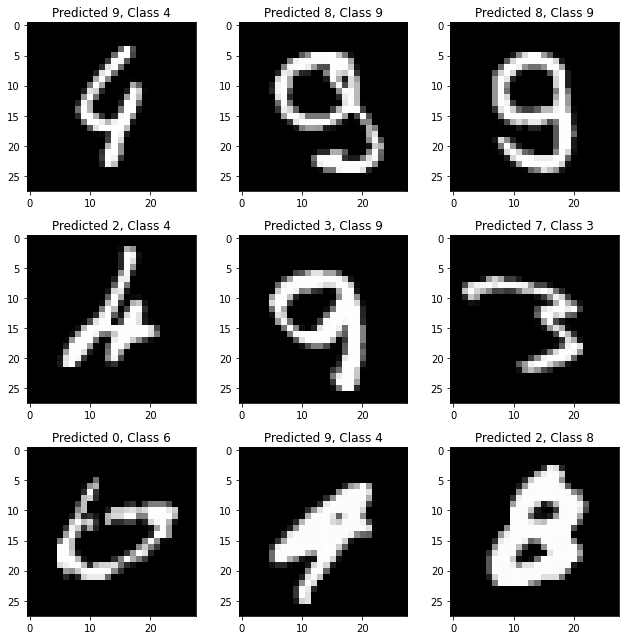

In [25]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.tight_layout()
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    
plt.tight_layout()